In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''


## Multi-Class Logistic Regression

### Introduction
This notebook implements Multi-Class Logistic Regression using the Softmax function to model categorical distributions.

## Mathematical Formulation
For a given input feature vector $ x $, we compute class-wise activations:
$$
a_n = \phi_n^T x, \quad n = 1, 2, ..., N
$$
where $ \phi_n $ are the parameter vectors for each class.

We then compute the class probabilities using the Softmax function:
$$
\lambda_n = \frac{\exp(a_n)}{\sum_{m=1}^{N} \exp(a_m)}
$$
This ensures that the probabilities are positive and sum to one.

The log-likelihood function for training is:
$$
L = \sum_{i=1}^{I} \log P(w_i | x_i)
$$
where $ w_i $ is the true class label for the $ i $-th data point.

The gradient and Hessian for optimization are given by:
$$
\frac{\partial L}{\partial \phi_n} = - \sum_{i=1}^{I} (y_{in} - \delta[w_i - n]) x_i
$$
$$
\frac{\partial^2 L}{\partial \phi_m \partial \phi_n} = - \sum_{i=1}^{I} y_{im} (\delta[m - n] - y_{in}) x_i x_i^T
$$
where $ y_{in} $ is the predicted probability for class $ n $.

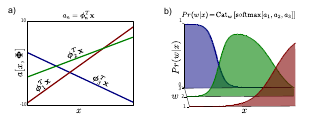

Fig.19 Multi-class logistic regression. a) We form one activation for each class based on linear functions of the data. b) We pass these activations through the softmax function to create the distribution P r(w|x) which is shown here as a function of x. The softmax function takes the three real- valued activations and returns three positive values that sum to one, ensuring that the distribution P r(w|x) is a valid probability distribution for all x.

## Implementation in Python


In [1]:

import numpy as np
from scipy.optimize import minimize

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def loss_function(phi, X, y, num_classes):
    N, D = X.shape
    phi = phi.reshape(num_classes, D)
    logits = X @ phi.T
    probs = softmax(logits)
    log_likelihood = -np.sum(np.log(probs[np.arange(N), y])) / N
    return log_likelihood

def train_multiclass_logreg(X, y, num_classes):
    N, D = X.shape
    phi_init = np.zeros((num_classes, D))
    result = minimize(loss_function, phi_init.ravel(), args=(X, y, num_classes), method='L-BFGS-B')
    return result.x.reshape(num_classes, D)

def predict(X, phi):
    logits = X @ phi.T
    return np.argmax(softmax(logits), axis=1)


## Conclusion
#This implementation demonstrates how to train and apply Multi-Class Logistic Regression using the Softmax function.



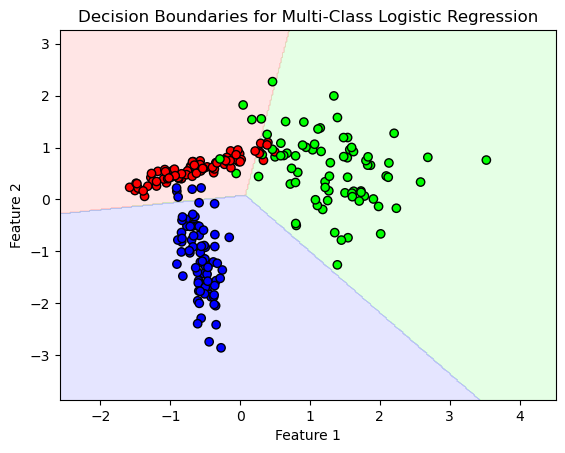

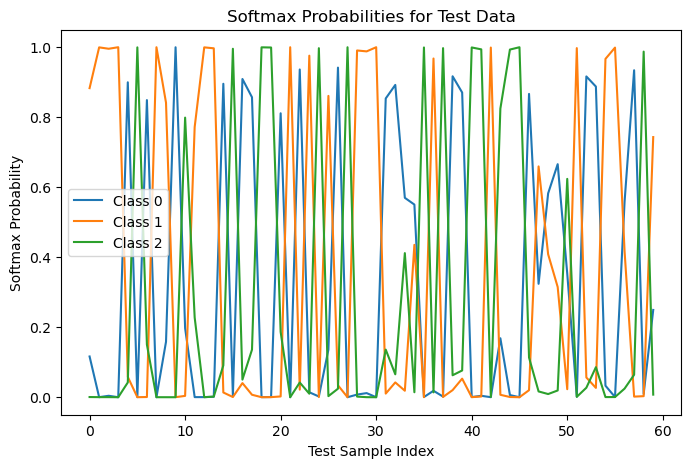

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Generate synthetic data
X, y = make_classification(n_samples=300, n_features=2, n_classes=3, n_clusters_per_class=1, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train multi-class logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Plot decision boundaries
def plot_decision_boundary(X, y, model):
    h = .02  # Step size for mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundaries for Multi-Class Logistic Regression")
    plt.show()

plot_decision_boundary(X_train, y_train, model)

# Plot softmax probabilities for test data
probs = model.predict_proba(X_test)
plt.figure(figsize=(8, 5))
for i in range(3):
    plt.plot(probs[:, i], label=f'Class {i}')
plt.xlabel('Test Sample Index')
plt.ylabel('Softmax Probability')
plt.title('Softmax Probabilities for Test Data')
plt.legend()
plt.show()



## Multi-class Logistic Regression and Random Classification Trees

## Multi-class Logistic Regression
Throughout this chapter, we have discussed binary classification. We now discuss how to extend these models to handle $N > 2$ world states. One possibility is to build $N$ one-against-all binary classifiers, each of which computes the probability that the $n$th class is present as opposed to any of the other classes. The final label is assigned according to the one-against-all classifier with the highest probability.

A more principled way to cope with multi-class classification problems is to describe the posterior $Pr(w|x)$ as a categorical distribution, where the parameters $\lambda = [\lambda_1, \dots, \lambda_N]$ are functions of the data $x$:

$$Pr(w|x) = \text{Cat}_w [\lambda[x]],$$  
where the parameters are in the range $\lambda_n \in [0, 1]$ and sum to one:

$$\sum_n \lambda_n = 1.$$  

To construct the function $\lambda[x]$, we define $N$ activations (one for each class):

$$a_n = \phi_n^T x,$$  
where $\phi_1, \dots, \phi_N$ are parameter vectors. The categorical distribution entries are computed using the softmax function:

$$\lambda_n = \text{softmax}_n [a_1, a_2, \dots, a_N] = \frac{\exp[a_n]}{\sum_{m=1}^{N} \exp[a_m]}.$$  

To learn the parameters $\theta = \{\phi_1, \dots, \phi_N\}$ given training pairs $(w_i, x_i)$, we optimize the log-likelihood of the training data:

$$L = \sum_{i=1}^{I} \log Pr(w_i | x_i).$$  

The first and second derivatives of the log-likelihood are given by:

$$\frac{\partial L}{\partial \phi_n} = - \sum_{i=1}^{I} (y_{in} - \delta[w_i - n])x_i,$$  

$$\frac{\partial^2 L}{\partial \phi_m \partial \phi_n} = - \sum_{i=1}^{I} y_{im} (\delta[m - n] - y_{in}) x_i x_i^T.$$  

where we define:

$$y_{in} = Pr(w_i = n | x_i) = \text{softmax}_n [a_{i1}, a_{i2}, \dots, a_{iN}].$$  

## Random Classification Trees

A random classification tree evaluates data against a function $q[x]$ that was randomly chosen from a predefined family of possible functions. The data proceeds one way if the response of this function exceeds a threshold $\tau$ and the other way if not.

The threshold $\tau$ is selected to maximize the log-likelihood:

$$L = \sum_{i=1}^{I} \Big( (1 - H[q[x_i] - \tau]) \log \text{Cat}_{w_i} \lambda[l] + H[q[x_i] - \tau] \log \text{Cat}_{w_i} \lambda[r] \Big),$$  

where $H[\cdot]$ is the Heaviside step function. The categorical parameters for each branch are set using maximum likelihood:

$$\lambda_k^{[l]} = \frac{\sum_{i=1}^{I} \delta[w_i - k] (1 - H[q[x_i] - \tau])}{\sum_{i=1}^{I} (1 - H[q[x_i] - \tau])},$$  

$$\lambda_k^{[r]} = \frac{\sum_{i=1}^{I} \delta[w_i - k] H[q[x_i] - \tau]}{\sum_{i=1}^{I} H[q[x_i] - \tau]}.$$  

The classification tree is trained recursively, with new random classifiers applied to the left and right branches independently.

## Random Forests and Ferns

1. **Random Forest**: A collection of random trees where each tree uses a different randomly chosen set of functions. The final classification is an average of the predictions made by individual trees.
2. **Ferns**: Trees where the same function is used at each level. This ensures every data point undergoes the same sequence of functions, optimizing efficiency.

## Relation to Non-Probabilistic Models

Many common classification algorithms (e.g., neural networks, AdaBoost, SVMs) are non-probabilistic. While these approaches have different objective functions, probabilistic models offer several advantages:

- They naturally produce estimates of certainty.
- They are easily extensible to multi-class problems.
- They relate well to Bayesian formulations.

### Conclusion
Probabilistic classification techniques, such as multi-class logistic regression and random classification trees, provide robust and interpretable solutions to real-world problems. They offer certainty estimates and can be efficiently implemented at scale.



Logistic Regression Accuracy: 0.855
Random Forest Accuracy: 0.905
Confusion Matrix (Logistic Regression):
 [[55  4  8]
 [ 9 47  1]
 [ 5  2 69]]
Confusion Matrix (Random Forest):
 [[59  3  5]
 [ 8 49  0]
 [ 2  1 73]]
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        67
           1       0.89      0.82      0.85        57
           2       0.88      0.91      0.90        76

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.86       200

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        67
           1       0.92      0.86      0.89        57
           2       0.94      0.96      0.95        76

    accuracy                           0.91       200
   macro avg       0.91      0.90      0.90  

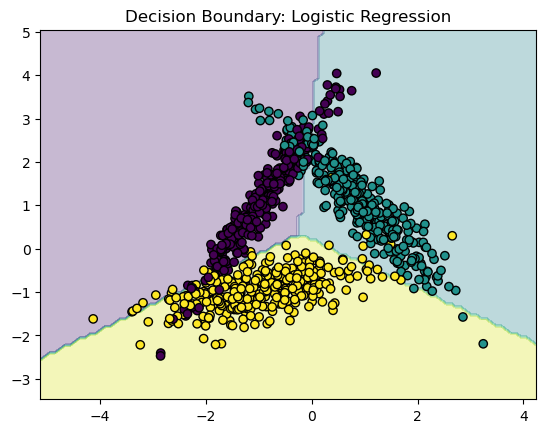

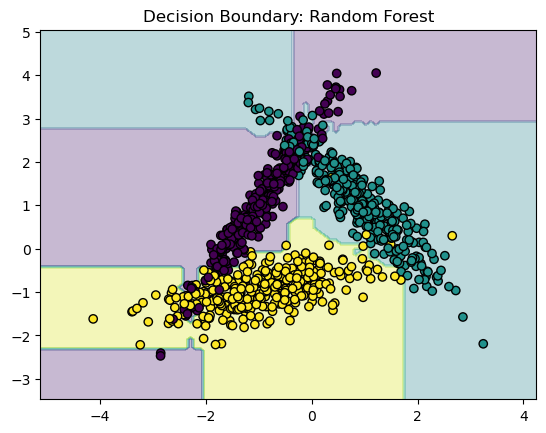

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Generate synthetic data
#X, y = make_classification(n_samples=1000, n_features=2, n_informative=3, n_redundant=0, n_classes=3, random_state=42)
# X, y = make_classification(n_samples=1000, n_features=2, n_classes=3, n_informative=2, n_redundant=0, random_state=42)
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-class Logistic Regression
# log_reg = LogisticRegression(multi_class='softmax', solver='lbfgs', max_iter=200)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

# Random Classification Tree (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg))
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

# Visualization
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(log_reg, X, y, "Decision Boundary: Logistic Regression")
plot_decision_boundary(rf, X, y, "Decision Boundary: Random Forest")


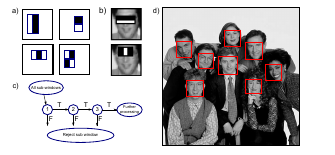

Fig.20 Fast face detection using a boosting method (Viola & Jones 2004). a) Each weak classiﬁer consists of the response of the image to a Haar- like ﬁlter, which is then passed through a step function. b) The ﬁrst two weak classiﬁers learned in this implementation have clear interpretations: the ﬁrst responds to the dark horizontal region belonging to the eyes and the second responds to the relative brightness of the bridge of the nose. c) The data passes through a cascade: most regions can be quickly rejected after evaluating only a few weak classiﬁers as they look nothing like faces. More ambiguous regions undergo further preprocessing. d) Example results. Adapted from Viola & Jones (2004).

## Fast Face Detection using a Boosting Method (Viola & Jones, 2004)

### Overview

Face detection assigns a label $ w \in \{0,1\} $ to a small region of an image $ x $, indicating whether a face is present $ (w = 1) $ or not $ (w = 0) $. This process must be repeated at every position and scale in the image, requiring an extremely fast classifier.

Viola & Jones (2004) presented a face detection system based on Adaboost, a non-probabilistic analogue of boosting methods. The final classification is based on:

$$
a = \phi_0 + \sum_{k=1}^{K} \phi_k f[x, \xi_k]
$$

where the nonlinear functions $ f[\cdot] $ are Heaviside step functions of projections of the data (weak classifiers that give a response of zero or one for each possible data vector $ x $):

$$
f[x, \xi_k] = \text{heaviside}[\xi_k^T x].
$$

As usual, the data vector $ x $ was prepended with a 1 to account for an offset.

### Training Process

- The system was trained on **5,000 faces** and **10,000 non-face regions**.
- Each image was represented as a **24 × 24** image patch.
- Since the model is non-smooth (due to the step function), **gradient-based optimization** was unsuitable.
- Instead, the system exhaustively searched through a very large number of pre-defined projections $ \xi_k $.

### Optimizations for Speed

Two key optimizations ensured fast execution:

1. **Cascade Structure:**
    - Training in boosting is incremental—weak classifiers are **incrementally added** to create a stronger classifier.
    - **Early rejection:** The first few weak classifiers reject **non-face** regions quickly, while ambiguous regions undergo further processing.
    - Later stages are trained with new negative examples **not rejected** by earlier stages.

2. **Fast Evaluation using Haar-like Filters:**
    - The chosen projections $ \xi_k $ consisted of Haar-like filters.
    - These filters require only a few operations to compute.

### Final Model Performance

- **4,297 weak classifiers** divided into a **32-stage cascade**.
- Detected **91.1%** of **507 frontal faces** across **130 images**.
- False positive rate: **< 1 per frame**.
- Processed images in **fractions of a second**.

### Pedestrian Detection

Viola et al. (2005) extended the method to **pedestrian detection in videos**:

- Included features spanning multiple frames to capture human motion.
- Used:
  - Image data
  - Difference images between adjacent frames
  - Offset difference images in four directions
- **Final system performance:**
  - **80% detection rate**.
  - False alarm rate: **1 false positive per 400,000 detections (≈ 1 per 2 frames).**

---




In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load an image
image_path = 'face.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


![image.png](attachment:image.png)

Fig.21 Boosting methods based on the thresholded responses of Haar functions have also been used for pedestrian detection in video footage. a) To improve detection rates two subsequent frames are used. The absolute diﬀerence between the frames is computed as is the diﬀerence when one of the frames is oﬀset in each of four directions. The set of potential weak classiﬁers consists of Haar functions applied to all six of these representations. b,c) Example results. Adapted from Viola et al. (2005)
```markdown
# Semantic Segmentation using TextonBoost

## Introduction

Semantic segmentation assigns a label $w \in \{1, ..., M\}$ to each pixel in an image, identifying which of $M$ object categories is present. Shotton et al. (2009) introduced **TextonBoost**, a segmentation method based on boosting, which uses texture-based features called **textons**.

## Mathematical Formulation

TextonBoost utilizes **JointBoost** (Torralba et al., 2007), a non-probabilistic boosting algorithm. The decision for each class is computed as a weighted sum of weak classifiers:

$$
 a_m = \phi_{0m} + \sum_{k=1}^{K} \phi_{km} f[x, \xi_k],
$$

where:
- $f[x, \xi_k]$ represents weak classifiers based on **textons**, which count the occurrence of specific texture types within a local region.
- The decision is made by selecting the class with the highest activation $a_m$.

## Algorithm

1. Convert the image into a **texton map** where each pixel is assigned a discrete texture type.
2. Define weak classifiers that count occurrences of a specific texton type in a rectangular neighborhood.
3. Train using boosting:
   - At each stage, select the best weak classifier from a randomly sampled set.
   - Update weights to emphasize misclassified regions.
4. Post-process with a **Conditional Random Field (CRF)** for spatial refinement.

## Implementation


import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Load input image
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Simulated Texton Map (in real cases, use a filter bank approach)
texton_map = image // 32  # Simple quantization

# Extract texton histogram features
def extract_texton_features(texton_map, patch_size=5):
    height, width = texton_map.shape
    features = np.zeros((height, width, 8))  # Example: 8 texton types
    
    for i in range(height):
        for j in range(width):
            x1, x2 = max(0, i - patch_size), min(height, i + patch_size)
            y1, y2 = max(0, j - patch_size), min(width, j + patch_size)
            patch = texton_map[x1:x2, y1:y2]
            hist, _ = np.histogram(patch, bins=8, range=(0, 8))
            features[i, j, :] = hist / np.sum(hist)
    
    return features

features = extract_texton_features(texton_map)

# Generate synthetic labels (for demonstration)
labels = (texton_map % 2).flatten()
X = features.reshape(-1, 8)

# Train AdaBoost Classifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50)
clf.fit(X, labels)

# Predict labels
predictions = clf.predict(X).reshape(texton_map.shape)

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Texton Map")
plt.imshow(texton_map, cmap='jet')
plt.subplot(1,2,2)
plt.title("Segmented Output")
plt.imshow(predictions, cmap='jet')
plt.show()

## Results and Discussion

- The model classifies pixels based on textural patterns.
- Weak classifiers count occurrences of textons in local regions.
- The use of a **CRF** refines the segmentation boundaries, reducing noise.

## References

- Shotton, J., et al. (2009). "TextonBoost: Joint Appearance, Shape, and Context Modeling for Multi-Class Object Recognition and Segmentation."
- Torralba, A., et al. (2007). "Sharing Features: Efficient Boosting Procedures for Multiclass Object Detection."
```



![image-2.png](attachment:image-2.png)

Fig.22 Semantic image labeling using “TextonBoost”. a) Original im- age. b) Image converted to textons – a discrete value at each pixel indicating the type of texture that is present. c) The system was based on weak clas- siﬁers that count the number of textons of a certain type within a rectangle that is oﬀset from the current position (yellow cross). d) This provides both information about the object itself (contains sheep-like textons) and nearby objects (near to grass-like textons). e,f) Another example of a weak clas- siﬁer. g) Test image. h) Per-pixel classiﬁcation is not very precise at the edges of objects and so i) a conditional random ﬁeld is used to improve the result. j) Examples of results and ground truth. Adapted from Shotton c et al. (2009) �2009 Springer.


In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Load input image
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Simulated Texton Map (in real cases, use a filter bank approach)
texton_map = image // 32  # Simple quantization

# Extract texton histogram features
def extract_texton_features(texton_map, patch_size=5):
    height, width = texton_map.shape
    features = np.zeros((height, width, 8))  # Example: 8 texton types
    
    for i in range(height):
        for j in range(width):
            x1, x2 = max(0, i - patch_size), min(height, i + patch_size)
            y1, y2 = max(0, j - patch_size), min(width, j + patch_size)
            patch = texton_map[x1:x2, y1:y2]
            hist, _ = np.histogram(patch, bins=8, range=(0, 8))
            features[i, j, :] = hist / np.sum(hist)
    
    return features

features = extract_texton_features(texton_map)

# Generate synthetic labels (for demonstration)
labels = (texton_map % 2).flatten()
X = features.reshape(-1, 8)

# Train AdaBoost Classifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50)
clf.fit(X, labels)

# Predict labels
predictions = clf.predict(X).reshape(texton_map.shape)

# Display results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Texton Map")
plt.imshow(texton_map, cmap='jet')
plt.subplot(1,2,2)
plt.title("Segmented Output")
plt.imshow(predictions, cmap='jet')
plt.show()



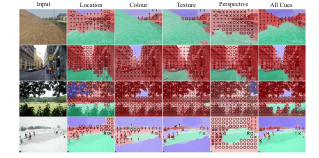

Fig.23 Recovering surface layout. The goal is to take an image and return a label indicating whether the pixel is part of a support surface (green pixels) vertical surface (red pixels) or the sky (blue pixels). Vertical surfaces were sub-classiﬁed into planar objects at diﬀerent orientations (left arrows, upward arrows and right arrows denote left-facing, fronto-parrallel and right- facing surfaces) and non-planar objects which can be porous (marked as ‘o’) or non-porous (marked as ‘x’. The ﬁnal classiﬁcation was based on (i) location cues (which include position in the image and position relative to the horizon), (ii) color cues, (iii) texture cues, and (iv) perspective cues, which were based on the statistics of line segments in the region. The ﬁgure shows example classiﬁcations for each of these cues alone and when combined. Adapted from Hoiem et al. (2007).
## Recovering Surface Layout

### Introduction
Recovering the surface layout of a scene involves assigning a label $ w \in \{1, 2, 3\} $ to each pixel, indicating whether it belongs to:
1. A support object (e.g., floor)
2. A vertical object (e.g., buildings, walls)
3. The sky

This process is based on local image data $ x $, utilizing a one-against-all classification strategy.

### Methodology
Hoiem et al. (2007) developed a system using **logitboosted classification trees**. Each classification tree acts as a weak classifier, and the final probability is computed by weighting their results together.

#### **Superpixel Representation**
The method operates on an **over-segmentation** of the scene into homogeneous **superpixels**, which are assumed to belong to the same object. Each superpixel is assigned a label $ w $ using a classifier based on a data vector $ x $, which contains:
- **Location cues**: Position in the image and relative to the horizon
- **Color cues**: Color distribution within the region
- **Texture cues**: Texture descriptors
- **Perspective cues**: Statistics of line segments in the region

#### **Multiple Segmentations**
To mitigate errors in the initial superpixel segmentation, multiple segmentations are computed and merged to provide a final per-pixel classification (Figure 9.23).

### **Classification and Subclassification**
The system initially assigns one of three main labels:
- **Support surfaces (e.g., floor, ground)**
- **Vertical surfaces (e.g., walls, trees, buildings)**
- **Sky**

Vertical surfaces are further subclassified into:
- **Planar objects**:
  - Left-facing
  - Fronto-parallel
  - Right-facing
- **Non-planar objects**:
  - Porous (e.g., trees)
  - Solid

### **Dataset & Performance**
The system was trained and tested on a diverse dataset of web-collected images, covering different environments (forests, cities, roads) and conditions (snowy, sunny, cloudy). Photos where the horizon was not visible were removed.

The classification achieved:
- **88.1% accuracy** in assigning the correct label among the three main categories
- **61.5% accuracy** in subclassifying vertical surfaces

### **Applications**
This method was foundational for creating **3D models from a single 2D image** (Hoiem et al. 2005). By leveraging perspective and segmentation techniques, the system enabled automatic scene reconstruction from photographs.


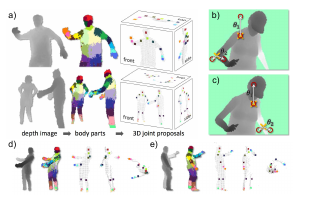

Fig.24 Identifying human parts. a) The goal of the system is to take a depth image x and assign a discrete label w to each pixel indicating which of 31 possible body parts is present. These depth labels are used to form proposals about the position of 3D joints. b) The classiﬁcation is based on decision trees. At each point in the tree, the data are divided according to the relative depth at two points (red circles) oﬀset relative to the current pixel (yellow crosses). In this example, this diﬀerence is large in both cases, whereas in c) this diﬀerence is small - hence these diﬀerences provide infor- mation about the pose. d,e) Two more examples of depth image, labeling and hypothesized pose. Adapted from Shotton et al.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load a random image
def load_random_image():
    img = cv2.imread(cv2.samples.findFile("lena.jpg"))  # Load a default test image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return img

# Perform superpixel segmentation
def segment_image(img, n_segments=200):
    segments = slic(img, n_segments=n_segments, compactness=10)
    return segments

# Extract features from superpixels
def extract_features(img, segments):
    gray = rgb2gray(img)
    features = []
    labels = []
    
    for segment in np.unique(segments):
        mask = segments == segment
        color_hist = np.mean(img[mask], axis=0)  # Mean color
        lbp = local_binary_pattern(gray[mask], P=8, R=1, method='uniform')
        lbp_hist = np.histogram(lbp, bins=10, range=(0, 10))[0]  # LBP histogram
        
        feature_vector = np.concatenate((color_hist, lbp_hist))
        features.append(feature_vector)
        labels.append(np.random.choice([0, 1, 2]))  # Random labels (Support, Vertical, Sky)
    
    return np.array(features), np.array(labels)

# Train classifier and evaluate
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy: {acc:.2f}")
    return clf

# Main execution
img = load_random_image()
segments = segment_image(img)
X, y = extract_features(img, segments)
clf = train_classifier(X, y)

# Show segmented image
plt.imshow(segments, cmap='jet')
plt.title("Superpixel Segmentation")
plt.show()



## Identifying Human Parts

## Introduction
Shotton et al. (2011) describe a system that assigns a discrete label $ w \in \{1, \dots, 31\} $, indicating which of 31 body parts is present at each pixel based on a depth image $ x $. The resulting distribution of labels is an intermediate representation in a system that proposes a possible configuration of the 3D joint positions in the Microsoft Kinect gaming system (Fig.24).

## Methodology
The classification is based on a forest of decision trees, where the final probability $ P_r(w|x) $ is an average (i.e., a mixture) of the predictions from a number of different classification trees. This ensemble approach mitigates biases introduced by the greedy method with which a single tree is trained.

### Decision Tree Structure
Within each tree, the decision about which branch a data point travels down is based on the difference in measured depths at two points, each of which is spatially offset from the current pixel. The offsets are inversely scaled by the distance to the pixel itself, ensuring that they address the same relative positions on the body when the person moves closer or further away from the depth camera.

### Training Dataset
The system was trained using a very large dataset of 900,000 depth images synthesized based on motion capture data. The decision forest consisted of three trees with a depth of 20.

## Performance
The system is capable of assigning the correct label 59% of the time, which provides a strong foundation for subsequent joint proposals in human pose estimation.

## Discussion
In this chapter, we have considered classification problems. All ideas applied to regression models in previous sections are also applicable to classification problems. However, for classification, the model includes a nonlinear mapping between the data $ x $ and the parameters of the distribution $ P_r(w|x) $ over the world $ w $. This means:
- We cannot find the maximum likelihood solution in closed form (although the problem remains convex).
- A full Bayesian solution requires approximations.

### Applications in Machine Vision
Classification techniques have many applications in machine vision. However, these models have no domain-specific information apart from what is provided during data preprocessing. This is both an advantage (broad applicability) and a disadvantage (lack of domain-specific optimizations).

In the remaining parts of the book, we will explore models that introduce increasing amounts of domain-specific knowledge to enhance performance.
```



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.transform import resize

# Load dataset (Example: Using random images from a sample dataset)
image_paths = "./dataset/*.jpg"  # Change this to actual dataset path
images = imread_collection(image_paths)

# Preprocessing: Convert to grayscale and resize
image_size = (64, 64)  # Resize for consistency
X = np.array([resize(rgb2gray(img), image_size) for img in images])
X = X.reshape(len(X), -1)  # Flatten for model training

y = np.random.randint(1, 32, len(X))  # Generate random labels for 31 body parts

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()